In [1]:
cd ..

C:\Users\giaco\sbp-abm\municipalities_abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from municipalities_abm.model import SBPAdoption

from municipalities_abm.custom_transformers import (
    TransformCensusFeaturesClsf,
    TransformCensusFeaturesRegr,
    TransformClimateFeatures,
    TransformSoilFeatures,
    )

%matplotlib inline

In [3]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm")

In [4]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=6)

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "model_validation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [6]:
path_to_adoption_port_real = "./model_validation/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)

In [7]:
path_to_adoption_munic_real = "./model_validation/data/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

# Model initialization and step

In [8]:
start_year = 1996

In [9]:
# Note that the model can be initialized with a seed to have reproducible results
model = SBPAdoption(initial_year=start_year)

In [10]:
stop_year = 2019

for i in range(start_year, stop_year):
    model.step()
    print("Step", str(i))

Negative adoption predicted of: [-0.000189]
Negative adoption predicted of: [-0.00081]
Negative adoption predicted of: [-0.00148]
Negative adoption predicted of: [-0.001848]
Negative adoption predicted of: [-0.001403]
Negative adoption predicted of: [-0.002634]
Negative adoption predicted of: [-0.000792]
Negative adoption predicted of: [-0.000553]
Negative adoption predicted of: [-0.000966]
Negative adoption predicted of: [-0.001292]
Negative adoption predicted of: [-0.000781]
Negative adoption predicted of: [-0.000982]
Negative adoption predicted of: [-0.000146]
Negative adoption predicted of: [-0.001342]
Negative adoption predicted of: [-0.001145]
Negative adoption predicted of: [-0.00159]
Negative adoption predicted of: [-0.001742]
Negative adoption predicted of: [-0.00131]
Negative adoption predicted of: [-0.000991]
Negative adoption predicted of: [-0.000899]
Negative adoption predicted of: [-0.00045]
Negative adoption predicted of: [-0.001157]
Negative adoption predicted of: [-0.0

Negative adoption predicted of: [-0.004269]
Negative adoption predicted of: [-0.001552]
Negative adoption predicted of: [-0.001118]
Negative adoption predicted of: [-0.000992]
Negative adoption predicted of: [-0.004735]
Negative adoption predicted of: [-0.003413]
Negative adoption predicted of: [-0.007854]
Step 2016
Negative adoption predicted of: [-0.007706]
Negative adoption predicted of: [-0.002502]
Negative adoption predicted of: [-0.000671]
Negative adoption predicted of: [-0.005668]
Negative adoption predicted of: [-0.003111]
Negative adoption predicted of: [-0.003217]
Negative adoption predicted of: [-0.001001]
Negative adoption predicted of: [-0.00917]
Negative adoption predicted of: [-0.000925]
Negative adoption predicted of: [-0.001944]
Negative adoption predicted of: [-0.004772]
Negative adoption predicted of: [-0.000769]
Negative adoption predicted of: [-0.009899]
Negative adoption predicted of: [-0.008342]
Negative adoption predicted of: [-0.004988]
Negative adoption predi

# Data collection

In [11]:
def collect_agent_level_yearly_adoption(abm_model):
    """
    Function to collect data at the individual agent level
    
    Returns
    -------
    municipalities_adoption : pd DataFrame
        Multiindex DataFrame reporting for each muninicipality and for each year the ratio of SBP adopted
    """
    municipality_agents = abm_model.schedule.agents
    municipalities = [munic.Municipality for munic in municipality_agents]
    
    # Create the empty df
    years = np.arange(start_year, stop_year)
    municipalities_adoption = pd.MultiIndex.from_product([municipalities, years])
    municipalities_adoption = municipalities_adoption.to_frame()
    municipalities_adoption.drop(municipalities_adoption.columns, axis=1, inplace=True)
    municipalities_adoption.index.rename(['Municipality', 'Year'], inplace=True)
    municipalities_adoption['predicted_adoption'] = None
    
    # Create a dictionary mapping to each municipality name the Series of its adoption in each year
    yearly_adoptions = [munic.yearly_adoption for munic in municipality_agents]
    map_dict = dict(zip(municipalities, yearly_adoptions))
    for k, v in map_dict.items():
        map_dict[k] = pd.Series(v)
        map_dict[k].name = 'predicted_adoption' # Necessary to use .udpdate() method

    # For each municipality, updates the values of adoption    
    for munic in municipalities:
        df = municipalities_adoption.loc[munic]
        df.update(map_dict[munic])
        municipalities_adoption.loc[munic] = df.values
        
    return municipalities_adoption

In [12]:
munic_yearly_adoption = collect_agent_level_yearly_adoption(model)

In [13]:
aggr_adoption_out = model.datacollector.get_model_vars_dataframe()
aggr_adoption_out.set_index('Year', inplace=True)

In [14]:
yearly_adoption_portugal_pred = aggr_adoption_out['Area sown in the last year [ha/y]']

# Model validation

## Macro-validation

### Quantitative

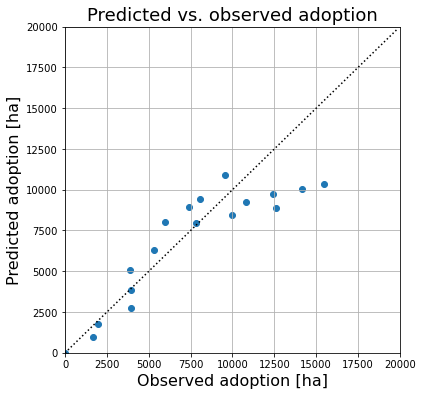

In [15]:
fig_pr, ax_pr = plt.subplots()
fig_pr.set_size_inches(6, 6)
ax_pr.set_xlabel("Observed adoption [ha]", fontsize=16)
ax_pr.set_ylabel("Predicted adoption [ha]", fontsize=16)
ax_pr.set_title("Predicted vs. observed adoption", fontsize=18)
lim = 20000
ax_pr.set_xlim(0, lim)
ax_pr.set_ylim(0, lim)
ax_pr.grid(True)
# Add diagonal
p = np.arange(0, lim, 100)
ax_pr.plot(p, p, 'k:')

yearly_adoption_portugal_pred_untill_2012 = yearly_adoption_portugal_pred.loc[yearly_adoption_portugal_pred.index <= 2012]
ax_pr.scatter(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_untill_2012.values)

In [16]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_untill_2012))
rrmse = rmse / yearly_adoption_portugal_real.values.std()
print("RMSE cumulative adoption: " + str(rmse))
print("Relative RMSE cumulative adoption: " + str(rrmse))

RMSE cumulative adoption: 2157.6399665967174
Relative RMSE cumulative adoption: 0.4920803153635127


### Qualitative

In [17]:
def plot_adoption_trend(predicted_adoption, real_adoption, max_y, fig_title):
    """
    Function to plot two adoptions, the predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(9, 4)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Hectares", fontsize=16)
    ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    ax_pr.plot(real_adoption.index, real_adoption.values, 'b:', linewidth=1, label='Observed adoption')
    ax_pr.plot(predicted_adoption.index, predicted_adoption.values, 'r--', linewidth=1, label='Predicted adoption')
    ax_pr.legend(loc='best')

    save_fig((fig_title))    

#### Plot predicted vs real adoption in Portugal

Saving figure Yearly SBP adoption in Portugal


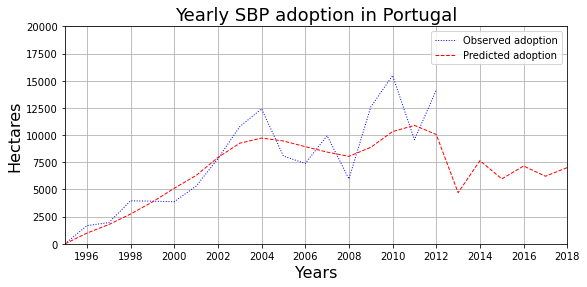

In [18]:
plot_adoption_trend(yearly_adoption_portugal_pred, yearly_adoption_portugal_real, 20000, "Yearly SBP adoption in Portugal")

#### Plot predicted vs real cumulative adoption in Portugal

In [19]:
cumulative_adoption_portugal_pred = aggr_adoption_out['Total area of SBP sown [ha]']
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

Saving figure Cumulative SBP adoption in Portugal


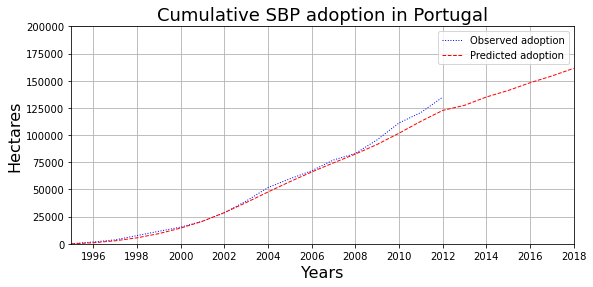

In [20]:
plot_adoption_trend(cumulative_adoption_portugal_pred, cumulative_adoption_portugal_real, 200000, "Cumulative SBP adoption in Portugal")

## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012, or the ending years of the simulation if it is before 2012.

(Note that for validation purposes the years will always been between 1996 and 2012, unless we want the error only on PCF project years)

### Quantitative

In [21]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real['adoption_in_year'], munic_yearly_adoption],
                                      axis=1, join='inner')
final_year_val = min(2012, stop_year)
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) > final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [22]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [23]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def micro_validation(adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    pred = adoption_rp['predicted_adoption'].values
    
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / real.std()
    print("Total RMSE:", str(rmse))
    print("Total relative RMSE:", str(rrmse))

    mae = mean_absolute_error(real, pred)
    print("Total MAE:", str(mae))  
    
    r2 = r2_score(real, pred)
    adj_r2 = adjusted_r2(r2, len(real), 21) # Taken number of features for sbp payments
    print("Total adjusted R2 score:", str(adj_r2))
    
    get_yearly_and_cumul_rmse(adoption_rp)

Total RMSE: 0.010197220981629026
Total relative RMSE: 1.0139931238844966
Total MAE: 0.0040566996543958565
Total adjusted R2 score: -0.03311057004445206


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
RMSE on year,0.004567,0.004106,0.003720,0.004761,0.005578,0.005614,0.007205,0.007328,0.008208,0.010701,0.007757,0.011967,0.009814,0.012130,0.019731,0.013268,0.018197
Relative RMSE on year,0.950253,0.946831,0.977912,0.953991,1.051672,1.095231,0.953546,1.042201,0.966346,0.986809,1.602611,1.000325,1.422964,1.081069,0.980234,1.084718,0.984536
RMSE till year,0.004567,0.004343,0.004146,0.004308,0.004590,0.004776,0.005193,0.005505,0.005868,0.006514,0.006637,0.007233,0.007463,0.007889,0.009167,0.009476,0.010197
Relative RMSE till year,0.950253,0.948693,0.952816,0.952773,0.977664,0.997851,0.978744,0.971340,0.956485,0.958477,0.998763,0.987410,1.021921,1.031219,1.013622,1.021541,1.013993


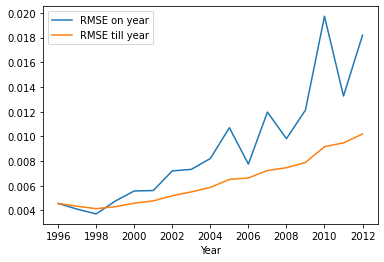

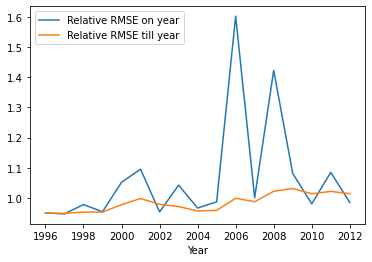

In [25]:
micro_validation(munic_adoption_real_pred)

### Qualitative

In [26]:
munic_adoption_real_pred_dist = munic_adoption_real_pred.copy()
munic_adoption_real_pred_dist.rename(columns={"adoption_in_year": "Observed adoption",
                                              "predicted_adoption": "Predicted adoption"}, inplace=True)

#### Number of predicted adopters over time

In [27]:
mask_pred = munic_adoption_real_pred_dist['Predicted adoption'] > 0
pred_yearly_adopters = munic_adoption_real_pred_dist['Predicted adoption'].loc[mask_pred].groupby('Year').count()
mask_real = munic_adoption_real_pred_dist['Observed adoption'] > 0
real_yearly_adopters = munic_adoption_real_pred_dist['Observed adoption'].loc[mask_real].groupby('Year').count()

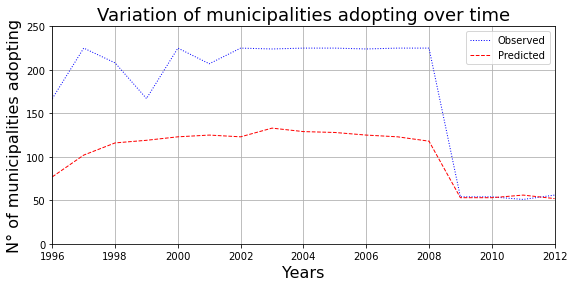

In [28]:
# Base figure
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(9, 4)
ax_ad.set_xlabel("Years", fontsize=16)
ax_ad.set_ylabel("N° of municipalities adopting", fontsize=16)
ax_ad.set_title('Variation of municipalities adopting over time', fontsize=18)
ax_ad.set_xlim(pred_yearly_adopters.index[0], pred_yearly_adopters.index[-1])
xticks = [year for year in pred_yearly_adopters.index if year%2 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 250)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_yearly_adopters.index, real_yearly_adopters.values, 'b:', linewidth=1, label='Observed')
ax_ad.plot(pred_yearly_adopters.index, pred_yearly_adopters.values, 'r--', linewidth=1, label='Predicted')
ax_ad.legend(loc='best')

#save_fig((fig_title))

#### Average adoption of only adopters over time

In [29]:
pred_av_yearly_adoption = munic_adoption_real_pred_dist['Predicted adoption'].loc[mask_pred].apply(pd.to_numeric).groupby('Year').mean()
real_av_yearly_adoption = munic_adoption_real_pred_dist['Observed adoption'].loc[mask_real].apply(pd.to_numeric).groupby('Year').mean()

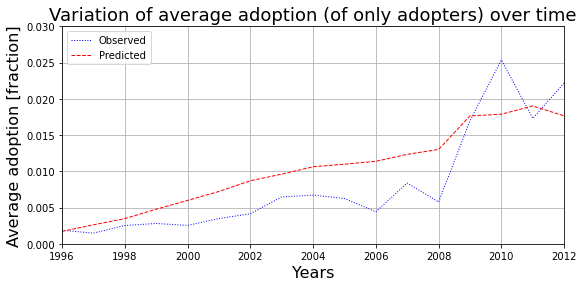

In [30]:
# Base figure
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(9, 4)
ax_ad.set_xlabel("Years", fontsize=16)
ax_ad.set_ylabel("Average adoption [fraction]", fontsize=16)
ax_ad.set_title('Variation of average adoption (of only adopters) over time', fontsize=18)
ax_ad.set_xlim(pred_av_yearly_adoption.index[0], pred_av_yearly_adoption.index[-1])
xticks = [year for year in pred_av_yearly_adoption.index if year%2 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 0.03)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_av_yearly_adoption.index, real_av_yearly_adoption.values, 'b:', linewidth=1, label='Observed')
ax_ad.plot(pred_av_yearly_adoption.index, pred_av_yearly_adoption.values, 'r--', linewidth=1, label='Predicted')
ax_ad.legend(loc='best')

#save_fig((fig_title))

#### Ditribution of adoption in each year in each municipality

In [31]:
num_0_real = (munic_adoption_real_pred_dist["Observed adoption"] == 0).astype(int).sum()
print("Total REAL number of time any municipality does NOT adopt over the years: ", num_0_real)

num_0_pred = (munic_adoption_real_pred_dist["Predicted adoption"] == 0).astype(int).sum()
print("Total PREDICTED number of time any municipality does NOT adopt over the years: ", num_0_pred)

Total REAL number of time any municipality does NOT adopt over the years:  1416
Total PREDICTED number of time any municipality does NOT adopt over the years:  2648


Text(0.5, 1.0, "Distribution of municipalities' adoption")

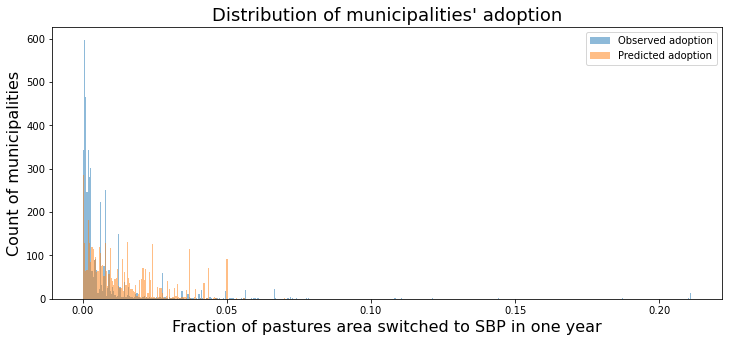

In [32]:
munic_adoption_real_pred_dist.replace(0, None, inplace=True) # To avoid plotting 0s
ax = munic_adoption_real_pred_dist.plot.hist(figsize=(12, 5), bins=500, alpha=0.5) 
ax.set_xlabel("Fraction of pastures area switched to SBP in one year", fontsize=16)
ax.set_ylabel("Count of municipalities", fontsize=16)
ax.set_title("Distribution of municipalities' adoption", fontsize=18)

#### Map based on adoption level for each municipality at the end of the simulation

In [33]:
import geopandas as gpd

In [34]:
def collect_agent_level_for_map(abm_model, year):
    """
    Function to collect cumulative adoption in a certain year (in ha and in fraction over pastures area)
    and the shape of the municialities in order to plot the map.
    
    Returns
    -------
    munic_cumul_adoption_and_shape : pd DataFrame
        DataFrame reporting for each muninicipality the total cumulative adoption in ha and its shape
    """
    municipality_agents = abm_model.schedule.agents
    #municipalities = [munic.Municipality for munic in municipality_agents]
    
    #munic_cumul_adoption_and_shape = pd.DataFrame(index=municipalities)
    munic_cumul_adoption_and_shape = gpd.GeoDataFrame()
    munic_cumul_adoption_and_shape['Total cumulative adoption [ha]'] = None
    munic_cumul_adoption_and_shape['Total cumulative adoption [fraction]'] = None
    munic_cumul_adoption_and_shape['geometry'] = None
    
    for munic in municipality_agents:
        yearly_adoption_until_year_ha = [v for k, v in munic.yearly_adoption_ha.items()
                                        if k <= year]
        munic_tot_cumul_adoption_year_ha = sum(yearly_adoption_until_year_ha)
        
        yearly_adoption_until_year = [v for k, v in munic.yearly_adoption.items()
                                     if k <= year]
        munic_tot_cumul_adoption_year = sum(yearly_adoption_until_year)
        
        munic_cumul_adoption_and_shape.loc[munic.Municipality] = (
            munic_tot_cumul_adoption_year_ha, 
            munic_tot_cumul_adoption_year,
            munic.shape
        )
    
    return munic_cumul_adoption_and_shape

In [35]:
year_for_map = 2012

In [36]:
pred_for_map = collect_agent_level_for_map(model, year_for_map)

In [37]:
# Collect observed adoption in year
geometry = pred_for_map['geometry']
munic_map_adoption_real = munic_yearly_adoption_real.loc[munic_yearly_adoption_real.index.get_level_values(1) == year_for_map]
munic_map_adoption_real.index = munic_map_adoption_real.index.droplevel(1)

real_for_map = pd.concat([munic_map_adoption_real['tot_cumul_adoption_until_year_ha'], geometry], axis=1)
real_for_map = gpd.GeoDataFrame(real_for_map)

Plot of area adopted in hectares

In [38]:
import contextily as ctx
import matplotlib

def plot_maps_no_0s(geodata, column_data, leg_label):
    """
    To plot maps side by side.
    Inputs to be given as lists of two elements, the first referring to the predicted adoption and the second to the
    observed one.
    
    For additional options for plotting with geopandas see https://geopandas.org/mapping.html
    For different backgrounds see https://contextily.readthedocs.io/en/latest/providers_deepdive.html
    """
    fig, axis = plt.subplots(ncols=len(geodata), figsize=(15, 8))

    for i in range(len(geodata)):
        geodata_no_0 = geodata[i].loc[geodata[i][column_data[i]] != 0]
        geodata_no_0.crs = "EPSG:3857"
        transparency = 0.6
        if i == 0: # Legend scale based on predicted values
            sc_min = min(geodata_no_0['Total cumulative adoption [ha]'])
            sc_max = max(geodata_no_0['Total cumulative adoption [ha]']) 
        geodata_no_0.plot(ax=axis[i], column=column_data[i],
                          cmap="OrRd", #cmap='coolwarm',
                          alpha=transparency, edgecolor='k',
                          legend=True, norm=matplotlib.colors.LogNorm(vmin=sc_min, vmax=sc_max),
                          legend_kwds={'label': leg_label[i]})
        ctx.add_basemap(axis[i], source=ctx.providers.Stamen.Terrain)   

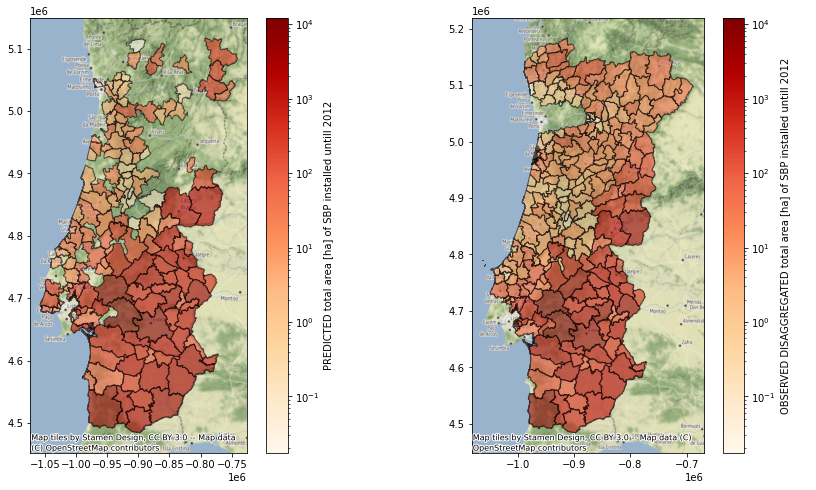

In [39]:
pred_leg_label = "PREDICTED total area [ha] of SBP installed untill " + str(year_for_map)
real_leg_label = "OBSERVED DISAGGREGATED total area [ha] of SBP installed untill " + str(year_for_map)
plot_maps_no_0s([pred_for_map, real_for_map], ['Total cumulative adoption [ha]', 'tot_cumul_adoption_until_year_ha'],
                [pred_leg_label, real_leg_label])

Plot of fraction of pastures area adopted (**Not for validation since not compared with real one move to experiments only**)

In [40]:
import contextily as ctx

def plot_map_no_0s(geodata, column_data, leg_label):
    """
    To plot only one map.
    
    For other options for plotting with geopandas see https://geopandas.org/mapping.html
    """
    geodata_no_0 = geodata.loc[geodata[column_data] != 0]
    geodata_no_0.crs = "EPSG:3857"
    transparency = 0.6
    ax = geodata_no_0.plot(figsize=(10, 8), column=column_data,
                            cmap='coolwarm', alpha=transparency, edgecolor='k',
                            legend=True,
                            legend_kwds={'label': leg_label})
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain)    

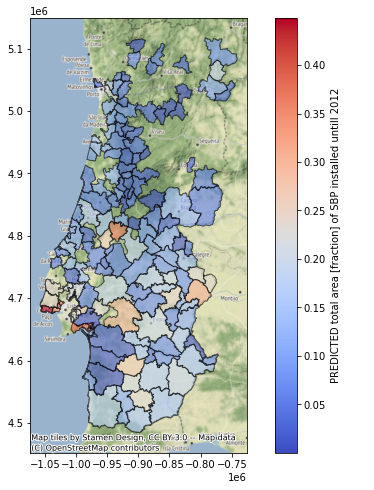

In [41]:
frac_leg_label = "PREDICTED total area [fraction] of SBP installed untill " + str(year_for_map)
plot_map_no_0s(pred_for_map, 'Total cumulative adoption [fraction]', frac_leg_label)